In [42]:
# %pip install PyMySQL
# %pip install pandas
# %pip install cryptography
# %pip install torch torchvision torchaudio

# 터미널에서 mysql에 사용자 추가하는 법
# mysql> CREATE user '사용자'@'localhost' IDENTIFIED BY '사용자_비밀번호';
# mysql> GRANT ALL PRIVILEGES ON *.* to '사용자'@'localhost'; # 모든 DB에 접근 가능 *.*
# mysql> FLUSH PRIVILEGES; # 새로운 세팅 적용
# 참고:http://bigdata.dongguk.ac.kr/lectures/DB/_book/python%EC%97%90%EC%84%9C-mysql%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98-%EC%A0%91%EA%B7%BC.html

import pymysql
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [43]:
con = pymysql.connect(host='localhost', user= 'kevinmj12', password='kookbop', db='kookbob', charset='utf8') # mysql connection 연결
cur = con.cursor() # connection으로부터 cursor 생성

sql = "SELECT user.user_num, review.review_user_id, review.review_menu_id_reviewd, review.menu_name, review.star, review.review_like FROM review INNER JOIN user ON review.review_user_id = user.nickname ORDER BY review.review_menu_id_revied desc" 
# sql = "SELECT * FROM review"
cur.execute(sql) # sql문 실행

rows = cur.fetchall()
data = pd.DataFrame(rows)
testData = pd.DataFrame(rows)
data

,0,1,2,3,4,5
0,3,jongbin,1,묵채비빔밥,5.0,0
1,3,jongbin,2,파채부대덮밥,4.0,0
2,3,jongbin,3,짜장면,1.0,0
3,3,jongbin,4,비빔국수,0.0,0
4,3,jongbin,5,비빔밥,5.0,0
5,2,jihun,5,비빔밥,1.0,0
6,2,jihun,3,짜장면,5.0,0
7,2,jihun,1,묵채비빔밥,1.0,5


In [44]:
menus = torch.LongTensor(data[2])
users = torch.LongTensor(data[0])
ratings = torch.FloatTensor(data[4])
menusTest = torch.LongTensor(testData[2])
usersTest = torch.LongTensor(testData[0])
ratingsTest = torch.FloatTensor(testData[4])
users

tensor([3, 3, 3, 3, 3, 2, 2, 2])

In [45]:
rank = 10 # Latent Vector의 개수
numMenus = menus.max()+1 # index 해결을 위해 +1 처리, 실제 결과값의 0행 0열은 더미값이다.
numUsers = users.max()+1
mean = ratings.mean()

tensor(0.2830)
tensor(0.5663)
tensor(0.3144)


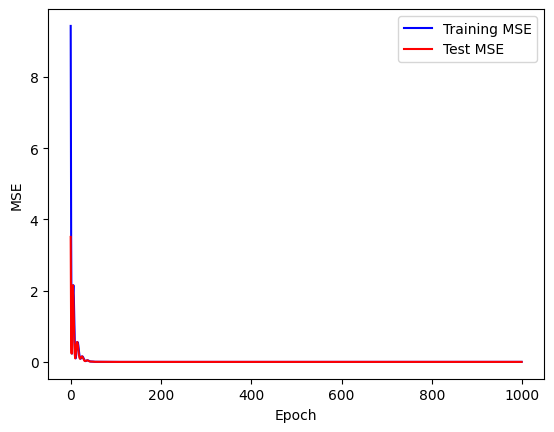

In [46]:
lambda1 = 0.5
lambda2 = 0.5
lambda3 = 0.5
lambda4 = 0.5
isOptimumLambda = False # 최적의 Lambda값을 찾기 위한 부울

X = []
Y = []
Y_test = [] # overfitting이 발생하는지 확인하기 위해 리스트에 값들 저장 후, pyplot을 통해 확인
prevDifference = 100
presentDifference = 0


while True:
  P = torch.randn(numMenus, rank, requires_grad=True) # menu Latent Factor 설정
  Q = torch.randn(numUsers, rank, requires_grad=True) # user Latent Factor 설정
  biasMenu = torch.randn(numMenus, requires_grad=True) # 정규화를 위한 menu Vector
  biasUser = torch.randn(numUsers, requires_grad = True) # 정규화를 위한 user Vecotor 
  optim = torch.optim.Adam([P, Q, biasMenu, biasUser], lr = 0.1) # optim.Adam()을 사용하여 머신러닝 시작
  X.clear()
  Y.clear()
  Y_test.clear()

  for epoch in range(1000):
    h = (P[menus] *Q[users]).sum(dim=1) + mean + biasMenu[menus] + biasUser[users] # 가설
    cost = F.mse_loss(h, ratings) # 비용
    loss = cost + lambda1*(P**2).mean() + lambda2*(Q**2).mean() + lambda3*(biasUser**2).mean() + lambda4*(biasMenu**2).mean() # 정규화

    optim.zero_grad()
    loss.backward()
    optim.step()

    X.append(epoch)
    Y.append(cost.item())
    with torch.no_grad():
      h_test = (P[menusTest] * Q[usersTest]).sum(dim=1) + mean + biasMenu[menusTest] + biasUser[usersTest]
      cost_test = F.mse_loss(h_test, ratingsTest)
      Y_test.append(cost_test.item())
    
    # with torch.no_grad():
      # if epoch % 100 == 0:
        # print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}\n h:{h}") # 비용과 가설의 학습 과정 확인 가능
        
  with torch.no_grad():
    presentDifference = (abs(h - ratings)).sum() # 실제 rating과 학습 이후 나온 rating을 비교하여 그 차이를 저장 (작을수록 정확하다)
    print(presentDifference)
    if isOptimumLambda: # 최적의 Lambda값을 찾았으므로 break
      break
    if prevDifference - presentDifference > 0: # 현재 학습이 이전 학습보다 잘 됨. Lambda값을 증가하며 계속 학습 진행
      lambda1 += 0.5
      lambda2 += 0.5
      lambda3 += 0.25
      lambda4 += 0.25
      prevDifference = presentDifference 
    else: # 현재 학습이 이전 학습보다 못 됨. 이전 학습했을 때의 Lambda값을 최적의 Lambda로 설정.
      lambda1 -= 0.5
      lambda2 -= 0.5
      lambda3 -= 0.25
      lambda4 -= 0.25
      isOptimumLambda = True

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot(X, Y, c="blue", label = "Training MSE")
plt.plot(X, Y_test, c="red", label = "Test MSE")
plt.legend()
plt.show()

In [47]:
resultMatrix = torch.transpose(torch.mm(P, torch.transpose(Q,0,1))[1:],0,1)+mean+biasMenu[1:]
resultMatrix = resultMatrix[1:] + biasUser.unsqueeze(1)[1:]
# print(torch.transpose(torch.mm(P, torch.transpose(Q,0,1)),0,1)+mean+biasMenu+biasUser.unsqueeze(1))
print(resultMatrix) # 0행 0열 제거 버전

originalMatrix = torch.transpose(torch.mm(P, torch.transpose(Q,0,1)),0,1)+mean+biasMenu+biasUser.unsqueeze(1)


todaysMenu = [1,2,3,4,5]
#print(originalMatrix[usernumber][todaysMenu])
userMenuSort, userMenuIndices = torch.sort(originalMatrix[0][todaysMenu], descending=True)
print(userMenuSort)
print(userMenuIndices)
userMenuRecommend = []
for each in userMenuIndices:
    userMenuRecommend.append(todaysMenu[each])

print(userMenuRecommend)
data


tensor([[2.7715, 2.7883, 2.8902, 2.6558, 2.7715],
        [1.0190, 1.9388, 4.9230, 4.7948, 1.0189],
        [4.9677, 3.9749, 0.9817, 0.0206, 4.9678]], grad_fn=<AddBackward0>)
tensor([[2.7500, 2.7715, 2.7883, 2.8902, 2.6558, 2.7715],
        [2.7500, 2.7715, 2.7883, 2.8902, 2.6558, 2.7715],
        [2.7891, 1.0190, 1.9388, 4.9230, 4.7948, 1.0189],
        [2.7987, 4.9677, 3.9749, 0.9817, 0.0206, 4.9678]],
       grad_fn=<AddBackward0>)
tensor([2.8902, 2.7883, 2.7715, 2.7715, 2.6558], grad_fn=<SortBackward0>)
tensor([2, 1, 4, 0, 3])
[3, 2, 5, 1, 4]


,0,1,2,3,4,5
0,3,jongbin,1,묵채비빔밥,5.0,0
1,3,jongbin,2,파채부대덮밥,4.0,0
2,3,jongbin,3,짜장면,1.0,0
3,3,jongbin,4,비빔국수,0.0,0
4,3,jongbin,5,비빔밥,5.0,0
5,2,jihun,5,비빔밥,1.0,0
6,2,jihun,3,짜장면,5.0,0
7,2,jihun,1,묵채비빔밥,1.0,5


In [48]:
sqlMenu = "SELECT * FROM menu"
cur.execute(sqlMenu) # sql문 실행

menuRows = cur.fetchall()
menuData = pd.DataFrame(menuRows)
menuIndex = menuData[0]
menuData
i = 1
for each in userMenuRecommend:
    print(i,"위")
    print(menuData[menuData[0]==each][2])
    i += 1
menuData

1 위
2    시래기뼈다귀해장국
Name: 2, dtype: object
2 위
1    파채부대덮밥
Name: 2, dtype: object
3 위
4    얼갈이두부된장국
Name: 2, dtype: object
4 위
0    묵채비빔밥
Name: 2, dtype: object
5 위
3    눈꽃치즈돈까스나베
Name: 2, dtype: object


,0,1,2,3,4,5
0,1,학생식당,묵채비빔밥,0,None,0
1,2,학생식당,파채부대덮밥,0,None,0
2,3,학생식당,시래기뼈다귀해장국,0,None,0
3,4,학생식당,눈꽃치즈돈까스나베,0,None,0
4,5,학생식당,얼갈이두부된장국,0,None,0
5,6,학생식당,치즈닭갈비납작당면,0,None,0
6,7,학생식당,트윈에비동,0,None,0
